In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [6]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Load Apple stock data
apple_stock = yf.Ticker("AAPL")
stock_data = apple_stock.history(period="max")

# Reset index and keep only the relevant columns
stock_data.reset_index(inplace=True)
stock_data = stock_data[['Date', 'Close']]

# Check the data
print(stock_data.head())

                       Date     Close
0 1980-12-12 00:00:00-05:00  0.098943
1 1980-12-15 00:00:00-05:00  0.093781
2 1980-12-16 00:00:00-05:00  0.086898
3 1980-12-17 00:00:00-05:00  0.089049
4 1980-12-18 00:00:00-05:00  0.091630


In [7]:
# Feature Engineering - Add Moving Averages as features
stock_data['MA10'] = stock_data['Close'].rolling(window=10).mean()  # 10-day moving average
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()  # 50-day moving average
stock_data['MA100'] = stock_data['Close'].rolling(window=100).mean()  # 100-day moving average
stock_data = stock_data.dropna()

# Create a column for the target (price on the next day)
stock_data['Target'] = stock_data['Close'].shift(-1)
stock_data = stock_data.dropna()

print(stock_data.head())


                         Date     Close      MA10      MA50     MA100  \
99  1981-05-06 00:00:00-04:00  0.094211  0.097610  0.090004  0.096104   
100 1981-05-07 00:00:00-04:00  0.095502  0.097094  0.090176  0.096070   
101 1981-05-08 00:00:00-04:00  0.096362  0.096749  0.090340  0.096095   
102 1981-05-11 00:00:00-04:00  0.094211  0.096276  0.090400  0.096169   
103 1981-05-12 00:00:00-04:00  0.094211  0.095975  0.090451  0.096220   

       Target  
99   0.095502  
100  0.096362  
101  0.094211  
102  0.094211  
103  0.093781  


In [10]:
# Define features and target variable
X = stock_data[['Close', 'MA10', 'MA50', 'MA100']]  # Features
y = stock_data['Target']  # Target is the next day's price

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale the data (helps with model performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_predictions = lr.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test, lr_predictions)

# Model 2: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_scaled, y_train)
rf_predictions = rf.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_predictions)

# Model 3: XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xg_reg.fit(X_train_scaled, y_train)
xg_predictions = xg_reg.predict(X_test_scaled)
xg_mse = mean_squared_error(y_test, xg_predictions)

# Print the Mean Squared Error for each model
print(f"Linear Regression MSE: {lr_mse}")
print(f"Random Forest MSE: {rf_mse}")
print(f"XGBoost MSE: {xg_mse}")


Linear Regression MSE: 4.005845357063629
Random Forest MSE: 8491.845154276174
XGBoost MSE: 8482.35718163391


In [12]:
from sklearn.metrics import mean_squared_error, r2_score

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict on the test set
lr_predictions = lr.predict(X_test_scaled)

# Calculate evaluation metrics
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

print(f"Linear Regression MSE: {lr_mse}")
print(f"Linear Regression R-squared: {lr_r2}")


Linear Regression MSE: 4.005845357063629
Linear Regression R-squared: 0.9989352387959094


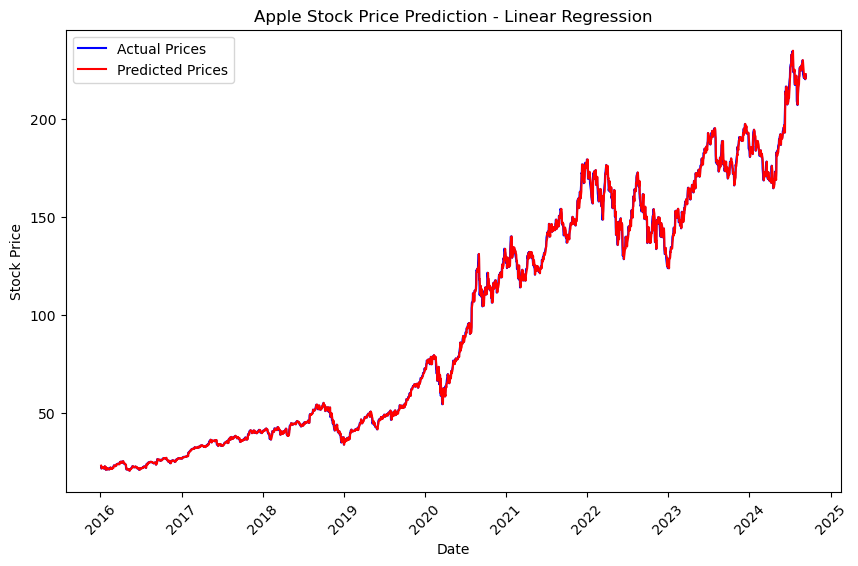

In [13]:
# Plot the actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Date'][-len(y_test):], y_test, label='Actual Prices', color='blue')
plt.plot(stock_data['Date'][-len(y_test):], lr_predictions, label='Predicted Prices', color='red')
plt.title('Apple Stock Price Prediction - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()


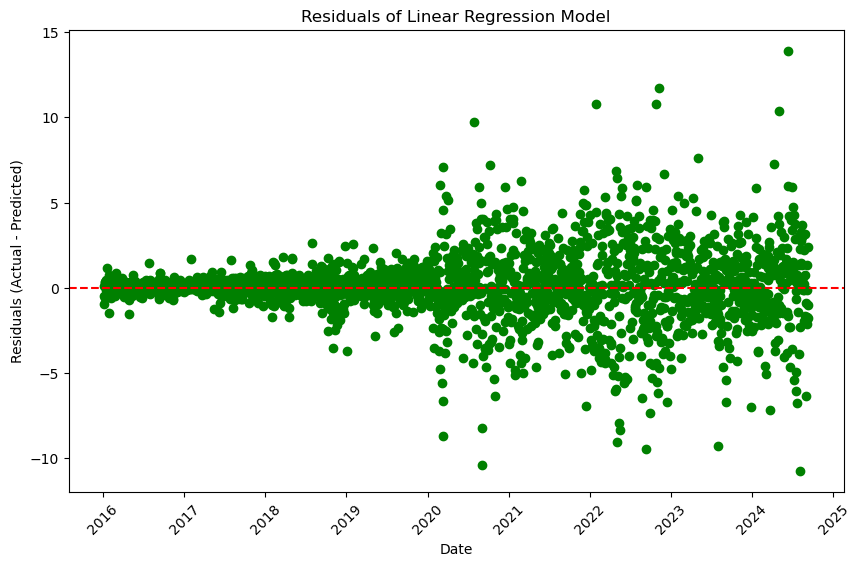

In [14]:
# Plot residuals
residuals = y_test - lr_predictions

plt.figure(figsize=(10, 6))
plt.scatter(stock_data['Date'][-len(y_test):], residuals, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals of Linear Regression Model')
plt.xlabel('Date')
plt.ylabel('Residuals (Actual - Predicted)')
plt.xticks(rotation=45)
plt.show()


In [16]:
from datetime import timedelta

# Get the last known date from the stock data
last_known_date = stock_data['Date'].iloc[-1]

# Predict the next day's stock price
last_known_data = X_test_scaled[-1].reshape(1, -1)
predicted_next_day_price = lr.predict(last_known_data)

# Calculate the next day's date
next_day_date = last_known_date + timedelta(days=1)

# Print the predicted stock price with the next day's date
print(f"Predicted stock price for {next_day_date.strftime('%Y-%m-%d')}: {predicted_next_day_price[0]}")


Predicted stock price for 2024-09-12: 222.78388335161821


In [18]:
from sklearn.metrics import r2_score, mean_absolute_error
from IPython.display import display

# Predict on the test set
lr_predictions = lr.predict(X_test_scaled)

# Calculate R-squared score for accuracy
r2 = r2_score(y_test, lr_predictions)

# Calculate Mean Absolute Error (MAE) in terms of dollars
mae = mean_absolute_error(y_test, lr_predictions)

# Calculate the average dollar difference between actual and predicted prices
dollar_diff = abs(y_test - lr_predictions)

# Add this difference to a DataFrame for better readability
results = pd.DataFrame({
    'Date': stock_data['Date'][-len(y_test):],
    'Actual Price': y_test,
    'Predicted Price': lr_predictions,
    'Dollar Difference': dollar_diff
})

# Display the table in a readable format using display()
print(f"R-squared (Accuracy of the model): {r2}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"On average, the predicted price was off by: ${dollar_diff.mean():.2f}")

# Display the table in a nice format
display(results.head(10))  # Display the first 10 rows of the table

# If you want to view the entire table (optional, depending on the size)
# display(results)


R-squared (Accuracy of the model): 0.9989352387959094
Mean Absolute Error (MAE): $1.26
On average, the predicted price was off by: $1.26


,Date,Actual Price,Predicted Price,Dollar Difference
8842,2016-01-05 00:00:00-05:00,22.832502,23.302418,0.469916
8843,2016-01-06 00:00:00-05:00,21.868870,22.851100,0.982230
8844,2016-01-07 00:00:00-05:00,21.984503,21.898184,0.086319
8845,2016-01-08 00:00:00-05:00,22.340479,22.006555,0.333924
8846,2016-01-11 00:00:00-05:00,22.664721,22.352406,0.312314
8847,2016-01-12 00:00:00-05:00,22.081999,22.668295,0.586296
8848,2016-01-13 00:00:00-05:00,22.564953,22.089806,0.475146
8849,2016-01-14 00:00:00-05:00,22.023048,22.561309,0.538261
8850,2016-01-15 00:00:00-05:00,21.916479,22.024485,0.108006
8851,2016-01-19 00:00:00-05:00,21.945955,21.915651,0.030304
